# Food101 Image Classification - Model Training

Fine-tune Vision Transformer (ViT) on Food101 dataset using transfer learning.

**Model**: google/vit-base-patch16-224-in21k  
**Dataset**: Food101 (15,150 training images)  
**Framework**: Hugging Face Transformers + PyTorch  
**MLOps**: MLflow tracking and Unity Catalog model registry

## Install Dependencies

In [ ]:
%pip install -q transformers==4.46.3 datasets==3.1.0 torch==2.5.1 torchvision==0.20.1 pillow==11.0.0 mlflow==2.18.0 scikit-learn==1.5.2 accelerate==1.1.1
dbutils.library.restartPython()

## Configuration

In [ ]:
os.environ['HF_HOME'] = '/tmp/huggingface'
os.environ['TRANSFORMERS_CACHE'] = '/tmp/huggingface/transformers'
os.environ['TORCH_HOME'] = '/tmp/torch'
os.environ['TMPDIR'] = '/tmp'

dbutils.widgets.text("catalog", "jdub_demo_aws", "Catalog")
dbutils.widgets.text("schema", "food101", "Schema")
dbutils.widgets.text("table_name", "bronze_images", "Table Name")
dbutils.widgets.text("model_name", "food101_cv_classifier", "Model Name")

CATALOG = dbutils.widgets.get("catalog")
SCHEMA = dbutils.widgets.get("schema")
TABLE_NAME = dbutils.widgets.get("table_name")
MODEL_NAME = dbutils.widgets.get("model_name")
FULL_TABLE_NAME = f"{CATALOG}.{SCHEMA}.{TABLE_NAME}"

MODEL_CHECKPOINT = "google/vit-base-patch16-224-in21k"
BATCH_SIZE = 8
LEARNING_RATE = 2e-4
NUM_EPOCHS = 8
NUM_CLASSES = 101
MAX_TRAIN_SAMPLES = 15150
MAX_VAL_SAMPLES = 5050

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment(f"/Users/{spark.sql('SELECT current_user()').collect()[0][0]}/food101_training")

print(f"Configuration: {FULL_TABLE_NAME}")
print(f"Model: {MODEL_CHECKPOINT} | Batch: {BATCH_SIZE} | LR: {LEARNING_RATE} | Epochs: {NUM_EPOCHS}")

In [ ]:
import io
import os
import random
import shutil
from pyspark.sql import functions as F
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import mlflow
import mlflow.transformers

df_train = spark.table(FULL_TABLE_NAME).filter(F.col("split") == "train").limit(MAX_TRAIN_SAMPLES)
df_val = spark.table(FULL_TABLE_NAME).filter(F.col("split") == "test").limit(MAX_VAL_SAMPLES)

train_data = df_train.select("image_bytes", "label_id", "label").toPandas()
val_data = df_val.select("image_bytes", "label_id", "label").toPandas()

print(f"Loaded - Train: {len(train_data)} | Val: {len(val_data)}")

## Load Data from Delta Table

In [ ]:
unique_classes = train_data['label'].unique()
random_classes = random.sample(list(unique_classes), min(10, len(unique_classes)))

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, class_name in enumerate(random_classes):
    class_samples = train_data[train_data['label'] == class_name]
    sample = class_samples.sample(1).iloc[0]
    img = Image.open(io.BytesIO(sample['image_bytes'])).convert('RGB')
    axes[idx].imshow(img)
    axes[idx].set_title(f"{sample['label']}\n(ID: {sample['label_id']})", fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\nDataset contains {len(unique_classes)} food classes")

## Visualize Sample Data

In [ ]:
def validate_data(data, name):
    corrupted_indices = []
    for idx in range(len(data)):
        try:
            img_bytes = data.iloc[idx]['image_bytes']
            if img_bytes is None or len(img_bytes) == 0:
                corrupted_indices.append(idx)
                continue
            Image.open(io.BytesIO(img_bytes)).convert('RGB')
        except:
            corrupted_indices.append(idx)
    
    if corrupted_indices:
        print(f"Removing {len(corrupted_indices)} corrupted {name} samples")
        data = data.drop(data.index[corrupted_indices]).reset_index(drop=True)
    return data

train_data = validate_data(train_data, "training")
val_data = validate_data(val_data, "validation")

print(f"Clean data - Train: {len(train_data)} | Val: {len(val_data)}")

## Validate Data Integrity

In [ ]:
class Food101Dataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row['image_bytes'])).convert('RGB')
        encoding = self.processor(image, return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding['labels'] = torch.tensor(row['label_id'], dtype=torch.long)
        return encoding

processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)
train_dataset = Food101Dataset(train_data, processor)
val_dataset = Food101Dataset(val_data, processor)

print(f"Datasets created: {len(train_dataset)} train, {len(val_dataset)} val")

## Create PyTorch Dataset

In [ ]:
output_dir = "/tmp/food101_cv_training"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

model = AutoModelForImageClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
)

device = "cuda" if torch.cuda.is_available() else "cpu"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    eval_strategy="epoch",
    save_strategy="no",
    logging_dir="/tmp/logs",
    logging_steps=10,
    remove_unused_columns=False,
    push_to_hub=False,
    dataloader_num_workers=0,
    dataloader_pin_memory=False,
    fp16=torch.cuda.is_available(),
    warmup_steps=100,
)

print(f"Device: {device} | Effective batch size: {BATCH_SIZE * 4} | FP16: {torch.cuda.is_available()}")

## Initialize Model and Training Configuration

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}

## Define Metrics

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

with mlflow.start_run(run_name="food101_cv_training") as run:
    mlflow.log_param("model_checkpoint", MODEL_CHECKPOINT)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("num_epochs", NUM_EPOCHS)
    mlflow.log_param("train_samples", len(train_dataset))
    mlflow.log_param("val_samples", len(val_dataset))
    
    train_result = trainer.train()
    eval_result = trainer.evaluate()
    
    final_model_path = "/tmp/food101_final_model"
    trainer.save_model(final_model_path)
    processor.save_pretrained(final_model_path)
    
    mlflow.log_metrics({
        "train_loss": train_result.training_loss,
        "val_accuracy": eval_result["eval_accuracy"],
        "val_f1": eval_result["eval_f1"],
        "val_loss": eval_result["eval_loss"]
    })
    
    print(f"Training Complete - Loss: {train_result.training_loss:.4f} | Accuracy: {eval_result['eval_accuracy']:.4f} | F1: {eval_result['eval_f1']:.4f}")

## Train Model with MLflow Tracking

In [ ]:
final_model_path = "/tmp/food101_final_model"
trained_model = AutoModelForImageClassification.from_pretrained(final_model_path)
trained_processor = AutoImageProcessor.from_pretrained(final_model_path)

sample_input = trained_processor(
    Image.open(io.BytesIO(train_data.iloc[0]['image_bytes'])).convert('RGB'),
    return_tensors="pt"
)
sample_input_df = pd.DataFrame({
    "pixel_values": [sample_input['pixel_values'].numpy().tolist()]
})

with mlflow.start_run(run_id=run.info.run_id):
    model_info = mlflow.transformers.log_model(
        transformers_model={
            "model": trained_model,
            "image_processor": trained_processor
        },
        artifact_path="model",
        task="image-classification",
        registered_model_name=f"{CATALOG}.{SCHEMA}.{MODEL_NAME}",
        input_example=sample_input_df.iloc[:1]
    )
    
    print(f"Model registered: {CATALOG}.{SCHEMA}.{MODEL_NAME}")
    print(f"Model URI: {model_info.model_uri}")

## Register Model to Unity Catalog

In [ ]:
model_full_name = f"{CATALOG}.{SCHEMA}.{MODEL_NAME}"
model_uri = f"models:/{model_full_name}@champion"
print(f"Loading model: {model_uri}")

loaded_model = mlflow.transformers.load_model(model_uri)
print(f"Model loaded successfully")

food_classes_df = spark.table(FULL_TABLE_NAME).select("label_id", "label").distinct().orderBy("label_id")
label_id_to_name = {row['label_id']: row['label'] for row in food_classes_df.collect()}

df_test = spark.table(FULL_TABLE_NAME).filter(F.col("split") == "test").limit(100)
test_data = df_test.select("image_bytes", "label_id", "label").toPandas()

test_idx = 3
test_image = Image.open(io.BytesIO(test_data.iloc[test_idx]['image_bytes'])).convert('RGB')
true_label = test_data.iloc[test_idx]['label']
true_label_id = test_data.iloc[test_idx]['label_id']

result = loaded_model(test_image, top_k=5)

def map_label(pred):
    label = pred['label']
    if label.startswith('LABEL_'):
        label_id = int(label.split('_')[1])
        return label_id_to_name.get(label_id, label)
    return label

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test_image)
ax.axis('off')

pred_label = map_label(result[0])
is_correct = pred_label == true_label
color = 'green' if is_correct else 'red'

ax.set_title(f"True: {true_label}\nPredicted: {pred_label} ({result[0]['score']:.1%})",
             fontsize=14, fontweight='bold', color=color, pad=20)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"INFERENCE TEST")
print(f"{'='*60}")
print(f"Model: {model_uri}")
print(f"True Label: {true_label} (ID: {true_label_id})")
print(f"Predicted: {pred_label} (Confidence: {result[0]['score']:.1%})")
print(f"Status: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")
print(f"\nTop 5 Predictions:")
for i, pred in enumerate(result[:5], 1):
    food_name = map_label(pred)
    marker = "→" if food_name == true_label else " "
    print(f"  {marker} {i}. {food_name:<30} {pred['score']:.1%}")
print(f"{'='*60}")

## Test Inference

Loading model: models:/jdub_demo_aws.food101.food101_cv_classifier@champion


2025/11/03 23:47:07 INFO mlflow.transformers: 'models:/jdub_demo_aws.food101.food101_cv_classifier@champion' resolved as 's3://databricks-e2demofieldengwest/b169b504-4c54-49f2-bc3a-adf4b128f36d/models/06e2b6ca-10a0-4705-a0c5-c0c663a981bc/versions/2cdf8b1a-9575-4358-b36b-4141ec1aa30e'


Device set to use cpu


Model loaded successfully


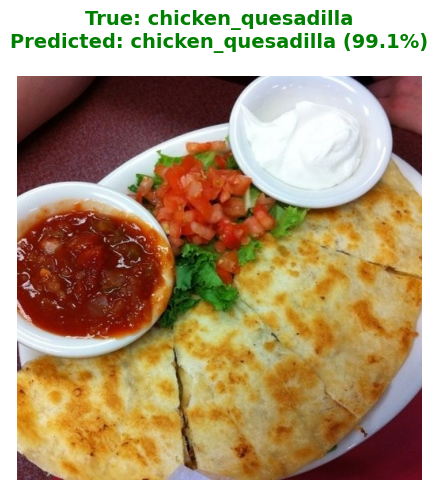


INFERENCE TEST
Model: models:/jdub_demo_aws.food101.food101_cv_classifier@champion
True Label: chicken_quesadilla (ID: 19)
Predicted: chicken_quesadilla (Confidence: 99.1%)
Status: ✓ CORRECT

Top 5 Predictions:
  → 1. chicken_quesadilla             99.1%
    2. breakfast_burrito              0.1%
    3. huevos_rancheros               0.0%
    4. tacos                          0.0%
    5. nachos                         0.0%


In [0]:
import matplotlib.pyplot as plt
from PIL import Image
import io
from pyspark.sql import functions as F
import mlflow.transformers

# Configuration (standalone - can run without other cells)
CATALOG = "jdub_demo_aws"
SCHEMA = "food101"
TABLE_NAME = "bronze_images"
MODEL_NAME = "food101_cv_classifier"
FULL_TABLE_NAME = f"{CATALOG}.{SCHEMA}.{TABLE_NAME}"

# Load model from Unity Catalog using champion alias
model_full_name = f"{CATALOG}.{SCHEMA}.{MODEL_NAME}"
model_uri = f"models:/{model_full_name}@champion"
print(f"Loading model: {model_uri}")

loaded_model = mlflow.transformers.load_model(model_uri)
print(f"Model loaded successfully")

# Create label mapping from Delta table
food_classes_df = spark.table(FULL_TABLE_NAME).select("label_id", "label").distinct().orderBy("label_id")
label_id_to_name = {row['label_id']: row['label'] for row in food_classes_df.collect()}

# Load test data
df_val = spark.table(FULL_TABLE_NAME).filter(F.col("split") == "test").limit(100)
val_data = df_val.select("image_bytes", "label_id", "label").toPandas()

# Select test image
test_idx = 3
test_image = Image.open(io.BytesIO(val_data.iloc[test_idx]['image_bytes'])).convert('RGB')
true_label = val_data.iloc[test_idx]['label']
true_label_id = val_data.iloc[test_idx]['label_id']

# Get predictions (loaded_model is already a pipeline)
result = loaded_model(test_image, top_k=5)

# Map LABEL_X to actual food names if needed
def map_label(pred):
    label = pred['label']
    if label.startswith('LABEL_'):
        label_id = int(label.split('_')[1])
        return label_id_to_name.get(label_id, label)
    return label

# Display image and predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test_image)
ax.axis('off')

# Determine if prediction is correct
pred_label = map_label(result[0])
is_correct = pred_label == true_label
color = 'green' if is_correct else 'red'

ax.set_title(f"True: {true_label}\nPredicted: {pred_label} ({result[0]['score']:.1%})",
             fontsize=14, fontweight='bold', color=color, pad=20)

plt.tight_layout()
plt.show()

# Print detailed results
print(f"\n{'='*60}")
print(f"INFERENCE TEST")
print(f"{'='*60}")
print(f"Model: {model_uri}")
print(f"True Label: {true_label} (ID: {true_label_id})")
print(f"Predicted: {pred_label} (Confidence: {result[0]['score']:.1%})")
print(f"Status: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")
print(f"\nTop 5 Predictions:")
for i, pred in enumerate(result[:5], 1):
    food_name = map_label(pred)
    marker = "→" if food_name == true_label else " "
    print(f"  {marker} {i}. {food_name:<30} {pred['score']:.1%}")
print(f"{'='*60}")

## Summary

**Model**: Vision Transformer fine-tuned on Food101  
**Registry**: `{CATALOG}.{SCHEMA}.{MODEL_NAME}`  
**Next Steps**: Use calibration split for conformal prediction in 02c-Conformal-Model-Wrapper-Endpoint.ipynb